# DS-GA 1019

# Lab 8 - Optimization
## Mar. 23, 2023

The basic components

- The objective function (also called the 'cost' function)


In [1]:
import numpy as np
objective = np.poly1d([1.3, 4.0, 0.6])
print(objective)

     2
1.3 x + 4 x + 0.6


- The optimizer


In [2]:
import scipy.optimize as opt
x_ = opt.fmin(objective, [3])
print("solution: x={}".format(x_))


Optimization terminated successfully.
         Current function value: -2.476923
         Iterations: 20
         Function evaluations: 40
solution: x=[-1.53845215]


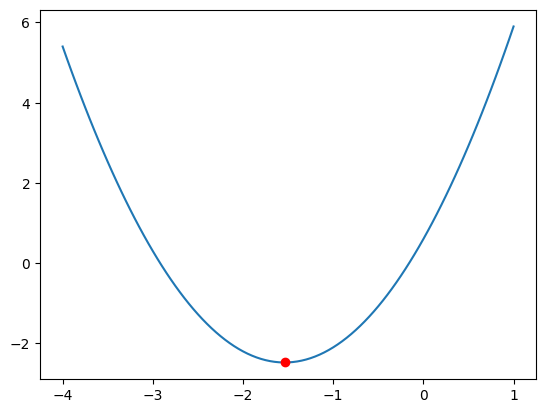

In [3]:
import matplotlib.pyplot as plt

x = np.linspace(-4,1,101)
plt.plot(x, objective(x))
plt.plot(x_, objective(x_), 'ro')
plt.show()

- With bounds

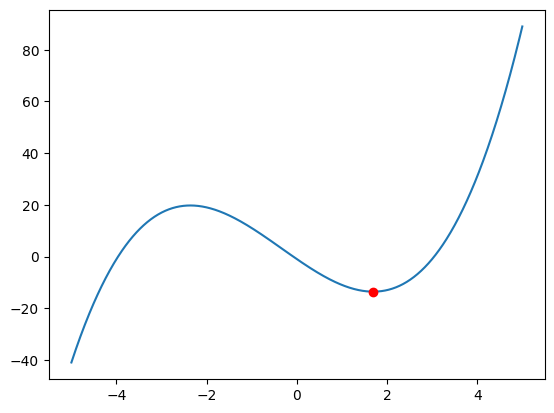

In [4]:
f = lambda x : x ** 3 + x ** 2 - 12 * x - 1
x = np.linspace(- 5, 5, 1000)

plt.plot(x, f(x))

result = opt.minimize_scalar(f, method="bounded", bounds=[0, 4])

f_min = f(result.x)
plt.plot(result.x, f_min,'ro')
plt.show()

### Optimization with constraints

min $x_1x_4(x_1+x_2+x_3)+x_3$
    
such that $x_1 x_2 x_3 x_4 \geq 25$  

$x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40$

$1 \leq x_1, x_2, x_3, x_4 \leq 5$

In [5]:
def objective(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    return x1*x4*(x1+x2+x3) + x3

def constraint1(x):
    return x[0]*x[1]*x[2]*x[3] - 25

def constraint2(x):
    return sum(p**2 for p in x) - 40

In [6]:
x0 = [2,4,4,2]
print(objective(x0))


44


In [7]:
b = (1,5)
bounds = [b,b,b,b]
con1 = {'type':'ineq','fun':constraint1}
con2 = {'type':'eq','fun':constraint2}

cons = [con1, con2]

In [8]:
solution = opt.minimize(objective, x0, bounds= bounds, constraints = cons)

In [9]:
solution

     fun: 17.014017283490524
     jac: array([14.57227612,  1.37940836,  2.37940836,  9.56414986])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([1.        , 4.74299977, 3.82114981, 1.37940832])

### Jax

Numpy for your Accelerator with autograd

In [10]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [11]:
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)


size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]
264 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
import numpy as np
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

271 ms ± 6.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
from jax import device_put

x = np.random.normal(size=(size, size)).astype(np.float32)
x = device_put(x)
%timeit jnp.dot(x, x.T).block_until_ready()

267 ms ± 5.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
x = np.random.normal(size=(size, size)).astype(np.float32)
%timeit np.dot(x, x.T)

122 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()

1.07 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

421 µs ± 4.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Derivatives

In [17]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(f"Jax Derivative {derivative_fn(x_small)}")


# verify using finite differences

def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])


print(f"Finite difference gradient: {first_finite_differences(sum_logistic, x_small)}")


# compute effecient hessians using jax
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

Jax Derivative [0.25       0.19661197 0.10499357]
Finite difference gradient: [0.24998187 0.1964569  0.10502338]


More information can be found at https://jax.readthedocs.io/en/latest/notebooks/quickstart.html

### Implementing a neural network  : Logical OR

| x_1 | x_2 | y   |
|---- | ----| --- |
| 1 | 0 | 1|
| 0 | 1 | 1|
| 1 | 1 | 1|
| 0 | 0 | 0|

In [18]:
data = np.array([[1,0,1],[0,1,1],[1,1,1],[0,0,0]])

In [19]:
X = data[:,0:2]
y = data[:,2].reshape(-1,1)
print(X)
print(y)

[[1 0]
 [0 1]
 [1 1]
 [0 0]]
[[1]
 [1]
 [1]
 [0]]


$y_{pred} = g(w_1 . x) . w_2 $

where $g(z) = \frac{1}{1+e^{-z}}$ is the sigmoid function

In [20]:
def sigmoid(z):

    return 1/(1+np.exp(-z))

In [21]:
class NeuralNetwork:
    def __init__(self,x,y,n):
        self.inputs = x
        self.targets = y
        
        self.w1 = np.random.rand(x.shape[1],n)        
        self.w2 = np.random.rand(n,1)                  
    
    def update(self,theta):
        self.w1 = theta.reshape(3,-1)[:-1,:]
        self.w2 = theta.reshape(3,-1)[-1,:].reshape(-1,1)
        
        return self.cost()
    
    def cost(self):
                
        preds = self.predictions()

        J = np.mean((self.targets - np.array(preds))**2)
        
        return J
    
    def predictions(self):
        preds = []
        for i in self.inputs:
        
            pred = sigmoid(i.dot(self.w1)).dot(self.w2)
            preds.append(pred)
        return preds

net = NeuralNetwork(X,y,2)


In [22]:
def fit(self):
    param_init = np.concatenate([net.w1,net.w2.T]).reshape(-1,)

    res = opt.minimize(net.update,param_init)
    
    return res


In [23]:
fit(net)

      fun: 6.457327367154259e-13
 hess_inv: array([[  9.13008176,  10.74641465,   3.38088786,  11.98103602,
         -5.05161182,   6.9099524 ],
       [ 10.74641465,  60.72847089,  11.70825432,  61.03814928,
        -44.39280302,  31.72653925],
       [  3.38088786,  11.70825432,   9.28811124,  11.49180938,
         -5.10761136,   7.00293739],
       [ 11.98103602,  61.03814928,  11.49180938,  63.6226896 ,
        -45.27950006,  32.50762926],
       [ -5.05161182, -44.39280302,  -5.10761136, -45.27950006,
         36.55745737, -23.12900342],
       [  6.9099524 ,  31.72653925,   7.00293739,  32.50762926,
        -23.12900342,  17.74182751]])
      jac: array([ 4.77180982e-07, -9.84409130e-09,  5.68398666e-07, -2.03569526e-08,
       -6.96363546e-07, -1.18613065e-06])
  message: 'Optimization terminated successfully.'
     nfev: 238
      nit: 30
     njev: 34
   status: 0
  success: True
        x: array([ 0.11719107,  3.45443266,  0.11960534,  3.47487513, -2.27221806,
        2.27221

In [24]:
net.predictions()

[array([0.99999977]),
 array([0.99999945]),
 array([0.99999857]),
 array([-3.16243105e-07])]

### Polynomial regression

Relationship between x and y is modelled as a nth degree polynomial

$y = b_0 + b_1x + b_2x^2 +....+ b_nx^n$

In [25]:
x = np.linspace(0,6.28,10)
e = np.random.uniform(low=0,high=0.25,size=10)

yn = np.sin(x) + e

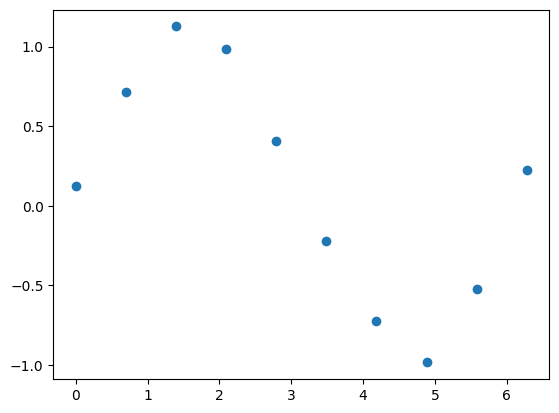

In [26]:
plt.scatter(x,yn)

In [27]:
class PolReg:
    def __init__(self,x,y,d):
        self.inputs = x
        self.targets = y
        
        self.w = np.random.rand(d+1)        
                         
    
    def update(self,theta):
        self.w = theta
        
        return self.cost()
    
    def cost(self):
                
        preds = self.predictions()
        
        J = np.mean((self.targets - np.array(preds))**2)

        return J
    
    def predictions(self,inp=None):
        preds = []
        if inp is None:
            inp = self.inputs
            
        for i in inp:
        
            pred = np.poly1d(self.w)(i)
            preds.append(pred)
            
        return preds

    def fit(self):
        param_init = self.w

        res = opt.minimize(self.update,param_init)

        return res



In [28]:
p2 = PolReg(x,yn,2)
p2.fit()

      fun: 0.2917997641968265
 hess_inv: array([[ 0.03993246, -0.25075845,  0.23323837],
       [-0.25075845,  1.6991064 , -1.85538771],
       [ 0.23323837, -1.85538771,  3.08913758]])
      jac: array([3.7252903e-09, 0.0000000e+00, 0.0000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 0.00638498, -0.24887792,  0.80544808])

In [29]:
p3 = PolReg(x,yn,3)
p3.fit()

      fun: 0.0076581623496519355
 hess_inv: array([[ 0.01359531, -0.12764785,  0.30233505, -0.11314646],
       [-0.12764785,  1.23794955, -3.08580052,  1.29029278],
       [ 0.30233505, -3.08580052,  8.39376477, -4.32526329],
       [-0.11314646,  1.29029278, -4.32526329,  3.94605963]])
      jac: array([ 3.30910552e-07,  5.34346327e-08,  3.37604433e-09, -2.03726813e-09])
  message: 'Optimization terminated successfully.'
     nfev: 75
      nit: 13
     njev: 15
   status: 0
  success: True
        x: array([ 0.08927149, -0.83455249,  1.75489266,  0.04114652])

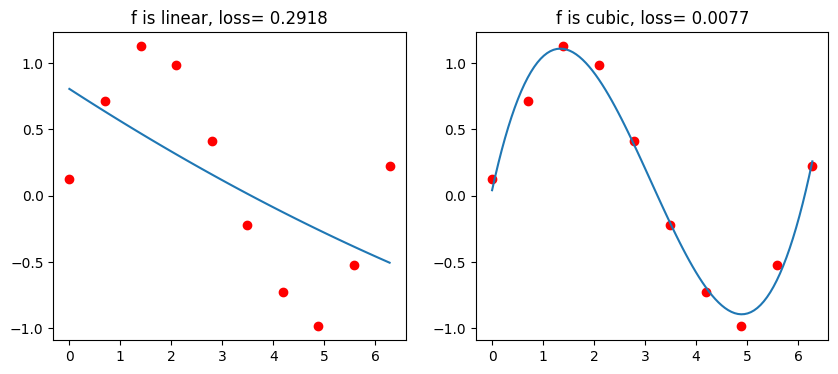

In [30]:
x1 = np.linspace(0,6.28,100)
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(x1,p2.predictions(x1))
plt.scatter(x,yn,c='red')
plt.title(f'f is linear, loss= {p2.cost():.4f}')

plt.subplot(122)
plt.plot(x1,p3.predictions(x1))
plt.scatter(x,yn,c='red')
plt.title(f'f is cubic, loss= {p3.cost():.4f}')

plt.show()

In [31]:
x**0

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

      fun: 0.007658162245180607
 hess_inv: array([[ 4.07767637, -4.48599363,  1.34171659, -0.11791216],
       [-4.48599363,  8.64117872, -3.16896495,  0.31000963],
       [ 1.34171659, -3.16896495,  1.26589755, -0.13019165],
       [-0.11791216,  0.31000963, -0.13019165,  0.0138229 ]])
      jac: array([-1.75150824e-08, -8.13984330e-08, -5.26067396e-07, -3.91187502e-06])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 13
     njev: 14
   status: 0
  success: True
        x: array([ 0.04113286,  1.75492981, -0.83456834,  0.08927319])


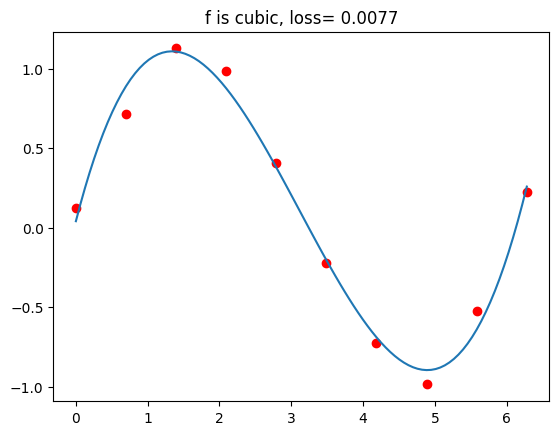

Optimization using hessian


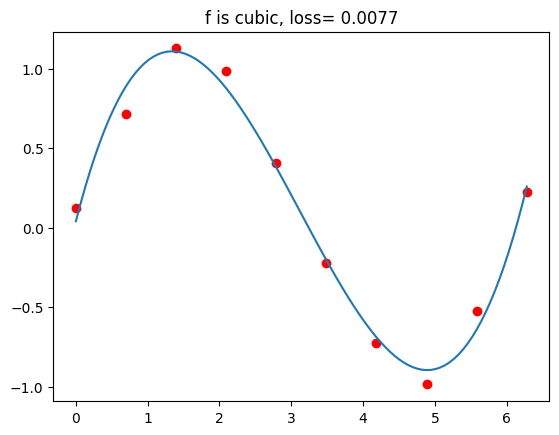

Optimization with no hessian and jacobian needed


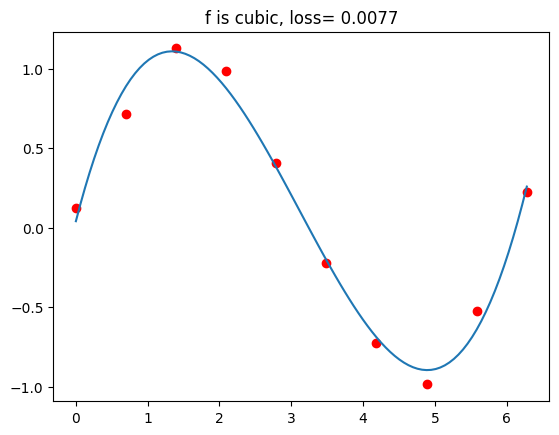

In [32]:
import jax.numpy as jnp
from jax import jit, grad, hessian
# NOTE: add this to make zero-order optimization work (as in numpy)

from jax.config import config
config.update("jax_enable_x64", True)

##

degree = 3
X = np.array([x ** j for j in range(degree + 1)]).T
wstart = np.random.rand(degree + 1)
def cost(w):
    return jnp.mean((jnp.dot(X, w) - yn) ** 2)

f = jit(cost)
fgrad = jit(grad(cost))
fhess = jit(hessian(cost))
res_nothing = opt.minimize(f, wstart)  # works poorly without 64bit floats

res = opt.minimize(f, wstart, jac=fgrad)  # default: BFGS, no hessian required

res_hess = opt.minimize(f, wstart, method='Newton-CG', jac=fgrad, hess=fhess)

print(res)
plt.figure()


x1 = np.linspace(0,6.28,100)
X1 = np.array([x1 ** j for j in range(degree + 1)]).T
plt.plot(x1, X1.dot(res['x']))
plt.scatter(x, yn, c='red')
plt.title(f'f is cubic, loss= {res["fun"]:.4f}')
plt.show()


print("Optimization using hessian")

x1 = np.linspace(0,6.28,100)
X1 = np.array([x1 ** j for j in range(degree + 1)]).T
plt.plot(x1, X1.dot(res_hess['x']))
plt.scatter(x, yn, c='red')
plt.title(f'f is cubic, loss= {res["fun"]:.4f}')
plt.show()

print("Optimization with no hessian and jacobian needed")

x1 = np.linspace(0,6.28,100)
X1 = np.array([x1 ** j for j in range(degree + 1)]).T
plt.plot(x1, X1.dot(res_nothing['x']))
plt.scatter(x, yn, c='red')
plt.title(f'f is cubic, loss= {res["fun"]:.4f}')
plt.show()


